In [2]:
import scipy.interpolate 
import scipy.optimize
import numpy 
import pandas 
import math
import matplotlib.pyplot as plt
import uncertainties as unc
from uncertainties import unumpy as unp

In [3]:
ttb6_raw = pandas.read_excel('TTB_Table_6_digitized.xlsx',header=5)
dens = ttb6_raw["SGV"]
dens = numpy.array(dens)

/Users/devinfan/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
temperatures = [20, 25, 15+(5/9)]
densities = dens

def true_proof(temp, dens):
    ttb6_raw = pandas.read_excel('TTB_Table_6_digitized.xlsx', header=5)
    ttb6_raw = ttb6_raw.dropna(axis=1)
    ttb6 = numpy.array(ttb6_raw, dtype=float)
    sg_data = ttb6[:, 4]
    proof_data = ttb6[:, 0]
    V_water = ttb6[:,2]
    V_ethonal = ttb6[:,1]
    interp_sg_proof = scipy.interpolate.interp1d(sg_data, proof_data)

    ttb1_raw = pandas.read_excel('TTB_Table_1_digitized.xlsx', header=5)
    ttb1_raw = ttb1_raw.fillna(0)
    ttb1 = numpy.array(ttb1_raw, dtype=float)
    ttb1 = ttb1[:, 1:]
    ttb1_y_size, ttb1_x_size = numpy.shape(ttb1)
    ttb1_ys = numpy.arange(0, ttb1_y_size)
    ttb1_xs = numpy.arange(1, ttb1_x_size+1)

    mole_fractions = []
    the_true_proofs = []
    for temp in temperatures:
        for dens in densities:
            temp_f = (temp * 9/5) + 32
            calculated_proof = interp_sg_proof(dens)
            proof_rd = numpy.floor(calculated_proof)
            T_rd = numpy.floor(temp_f)
            temp_idx = numpy.where(ttb1_xs == T_rd)
            proof_idx = numpy.where(ttb1_ys == proof_rd)
            if temp_idx[0].size > 0 and proof_idx[0].size > 0:
                temp_idx = temp_idx[0][0]
                proof_idx = proof_idx[0][0]
                f = ttb1[proof_idx, temp_idx]
                temp_plus_1 = T_rd + 1
                proof_plus_1 = proof_rd + 1
                f_proof_plus_1 = ttb1[proof_idx + 1, temp_idx]
                f_temp_plus_1 = ttb1[proof_idx, temp_idx + 1]
                df_dC = (f_proof_plus_1 - f) / (proof_plus_1 - proof_rd)
                df_dT = (f_temp_plus_1 - f) / (temp_plus_1 - T_rd)
                the_true_proof = f + (calculated_proof - proof_rd) * df_dC + (temp_f - T_rd) * df_dT
                the_true_proofs.append(the_true_proof)
                
            TP = numpy.floor(the_true_proof)
            TP_idx = TP-1
            TP_idx = int(TP_idx)
            if TP_idx < 199:
                VFE = the_true_proof /2
                VFW = V_water[TP_idx] + (the_true_proof - TP/ (TP+1-TP))*(V_water[TP_idx+1]-V_water[TP_idx])
            if TP_idx == 199:
                VFE = 100
                VFW =0
            de = 0.79313
            dw = 0.99904
            mmw=18.01528
            mme = 46.06844
            vfe = the_true_proof / 2
            mole_fraction = (vfe*de/mme)/((vfe*de/mme)+(VFW*dw/mmw))
            mole_fractions.append(mole_fraction)

    mole_fractions = numpy.array(mole_fractions)
    the_true_proofs = numpy.array(the_true_proofs)
    return mole_fractions,the_true_proofs

mf,tp=true_proof(temperatures,densities)

mf20=mf[0:200]
tp20=tp[0:200]
mf25=mf[200:400]
tp25=tp[200:400]
mf60=mf[400:600]
tp60=tp[400:600]

/var/folders/22/g0lkw7px703_ymv0l30dq4p80000gn/T/ipykernel_41503/1925677167.py:59: RuntimeWarning: invalid value encountered in double_scalars
  mole_fraction = (vfe*de/mme)/((vfe*de/mme)+(VFW*dw/mmw))


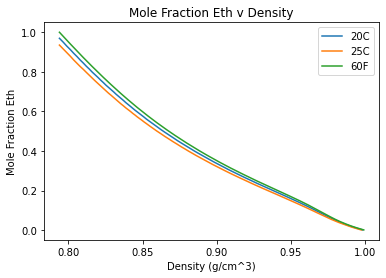

In [5]:
plt.plot(dens,mf20,label='20C')
plt.plot(dens,mf25,label='25C')
plt.plot(dens,mf60,label='60F')
plt.ylabel('Mole Fraction Eth')
plt.xlabel('Density (g/cm^3)')
plt.title('Mole Fraction Eth v Density')
plt.legend()
plt.show()

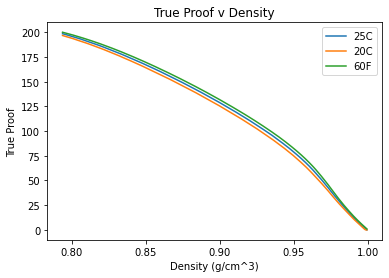

In [6]:
plt.plot(dens,tp20,label='25C')
plt.plot(dens,tp25,label='20C')
plt.plot(dens,tp60,label='60F')
plt.ylabel('True Proof')
plt.xlabel('Density (g/cm^3)')
plt.title('True Proof v Density')
plt.legend()
plt.show()

In [7]:
#Equation 2
#notes: me = , mf=mass in excel
lab_raw = pandas.read_excel('3.1raw.xlsx')
print(lab_raw)
rho_w = lab_raw["Density"]
rho_w = numpy.array(rho_w)
Mf = lab_raw['Mass']
Mf = numpy.array(Mf)
Mw = 59.914
Me = (34.238 + 34.243 + 34.241) / 3

  Sample   Temp    Mass  Density
0      1  25.20  57.797   0.9154
1      2  25.15  59.264   0.9713
2      3  24.75  56.434   0.8640
3      4  25.32  58.810   0.9549
4      5  23.30  55.330   0.8198
5      6  23.70  57.040   0.8849
6  water  23.05  59.900   0.9965
7    eth  23.20  54.500   0.7868


In [14]:
def fluid_density(rho_w, Me, Mw, Mf):

    Mf_prime = Mf - Me

    Vp = (Mw - Me) / (rho_w - 1000)

    Vf = (Mf_prime - Mw + Me) / (rho_w - 1000)

    rho_f = (Mf_prime / (Vf - Vp))/1000
    return rho_f



x=fluid_density(rho_w,Me,Mw,Mf)



s1=round(x[0],5)
s2=round(x[1],5)
s3=round(x[2],5)
s4=round(x[3],5)
s5=round(x[4],5)
s6=round(x[5],5)
sw=round(x[6],5)
se=round(x[7],5)
print("Mixture 1 Density:",s1)
print("Mixture 2 Density:",s2)
print("Mixture 3 Density:",s3)
print("Mixture 4 Density:",s4)
print("Mixture 5 Density:",s5)
print("Mixture 6 Density:",s6)
print("Pure Water Density:",sw)
print("Pure Ethonol Density:",se)



Uncertainty Mixture 1: 0.0021
Uncertainty Mixture 2: 0.013
Uncertainty Mixture 3: 0.0019
Uncertainty Mixture 4: 0.0063
Uncertainty Mixture 5: 0.0018
Uncertainty Mixture 6: 0.0024
Uncertainty Pure Water: 0.0031
Uncertainty Pure Ethanol: 0.0068
Mixture 1 Density: 0.84687
Mixture 2 Density: 0.94969
Mixture 3 Density: 0.7606
Mixture 4 Density: 0.91667
Mixture 5 Density: 0.69643
Mixture 6 Density: 0.79794
Pure Water Density: 0.99791
Pure Ethonol Density: 0.65118


In [87]:
def true_proof_VLE(temp_f, dens):
    ttb6_raw = pandas.read_excel('TTB_Table_6_digitized.xlsx', header=5)
    ttb6_raw = ttb6_raw.dropna(axis=1)
    ttb6 = numpy.array(ttb6_raw, dtype=float)
    sg_data = ttb6[:, 4]
    proof_data = ttb6[:, 0]
    V_water = ttb6[:,2]
    V_ethonal = ttb6[:,1]
    interp_sg_proof = scipy.interpolate.interp1d(sg_data, proof_data)

    ttb1_raw = pandas.read_excel('TTB_Table_1_digitized.xlsx', header=5)
    ttb1_raw = ttb1_raw.fillna(0)
    ttb1 = numpy.array(ttb1_raw, dtype=float)
    ttb1 = ttb1[:, 1:]
    ttb1_y_size, ttb1_x_size = numpy.shape(ttb1)
    ttb1_ys = numpy.arange(0, ttb1_y_size)
    ttb1_xs = numpy.arange(1, ttb1_x_size+1)

    calculated_proof = interp_sg_proof(dens)
    proof_rd = numpy.floor(calculated_proof)
    T_rd = numpy.floor(temp_f)
    temp_idx = numpy.where(ttb1_xs == T_rd)[0][0]
    proof_idx = numpy.where(ttb1_ys == proof_rd)[0][0]
    f = ttb1[proof_idx, temp_idx]
    temp_plus_1 = T_rd + 1
    proof_plus_1 = proof_rd + 1
    f_proof_plus_1 = ttb1[proof_idx + 1, temp_idx]
    f_temp_plus_1 = ttb1[proof_idx, temp_idx + 1]
    df_dC = (f_proof_plus_1 - f) / (proof_plus_1 - proof_rd)
    df_dT = (f_temp_plus_1 - f) / (temp_plus_1 - T_rd)
    the_true_proof = f + (calculated_proof - proof_rd) * df_dC + (temp_f - T_rd) * df_dT

                
    TP = numpy.floor(the_true_proof)
    TP_idx = TP-1
    TP_idx = int(TP_idx)
    if TP_idx < 199:
        VFE = the_true_proof /2
        VFW = V_water[TP_idx] + (the_true_proof - TP/ (TP+1-TP))*(V_water[TP_idx+1]-V_water[TP_idx])
    if TP_idx == 199:
        VFE = 100
        VFW =0
    de = 0.79313
    dw = 0.99904
    mmw=18.01528
    mme = 46.06844
    vfe = VFE
    mf = (vfe*de/mme)/((vfe*de/mme)+(VFW*dw/mmw))
    #print(mf)
    
    return mf,the_true_proof

t = [88]
d = .85
true_proof_VLE(t,d)

/Users/devinfan/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


(array([0.52425022]), array([160.48657718]))

In [88]:
#My Data
t1 = 17.025 * (9/5) + 32
d1 = 0.841825
t3 = 13.925 * (9/5) + 32
d3 = 0.86975
t6 = 15.6 * (9/5) + 32
d6 = 0.96555
t7 = 18.575 * (9/5) + 32
d7 = 0.9652
x1 = true_proof_VLE(t1,d1)[0]
x3 = true_proof_VLE(t3,d3)[0]
x6 = true_proof_VLE(t6,d6)[0]
x7 = true_proof_VLE(t7,d7)[0]
print("T1 = ", x1)
print("T3 = ", x3)
print("T6 = ", x6)
print("T7 = ", x7)

T1 =  0.6407331151000654
T3 =  0.49644771646126606
T6 =  0.11261485999817927
T7 =  0.1085106073757735


[]

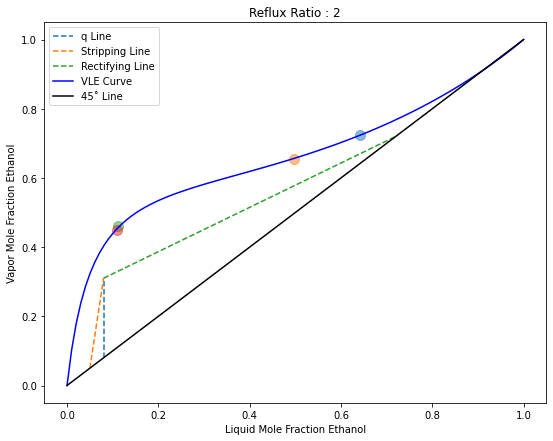

In [93]:
#Lab 3.2
antoine_water = [7.96681, 1668.21,228.00]
antoine_etOH = [8.04494, 1554.30,222.650]

A_12 = 1.6798
A_21 = 0.9227

def antoine (T, A, B, C) :

    log_P_sat = A - B / (T + C)
    P_sat = 10** (log_P_sat)
    return P_sat

def van_laar (x_1) :
    x_2 = 1 - x_1
    log_gamma_1 = A_12 * ( (A_21 * x_2) / (A_12 * x_1 + A_21 * x_2) ) **2
    log_gamma_2 = A_21 * ( (A_12 * x_1 ) /
    (A_12 * x_1 + A_21 * x_2 ) ) **2
    gamma_1 = numpy.exp(log_gamma_1)
    gamma_2 = numpy.exp (log_gamma_2)
    return gamma_1, gamma_2

def vle(T,x_1,P) :

    P1_sat = antoine (T, *antoine_etOH)
    P2_sat = antoine (T, *antoine_water)
    gamma_etOH, gamma_water = van_laar (x_1)

    y_a = gamma_etOH * x_1 * P1_sat / P #2a
    y_b = 1 - (gamma_water * (1 - x_1) * P2_sat) / P #2b
    return y_a - y_b

def calc_y(T,x_1,P):
    P1_sat = antoine(T, *antoine_etOH)
    gamma_etOH, gamma_water = van_laar(x_1)
    
    y_a = gamma_etOH * x_1 * P1_sat / P
    return y_a

xs = numpy. linspace (0, 1, 100)
guess_T = 50
P = 764.54

sol_T = []
sol_y = []
for i in range(len (xs)) :
    sol = scipy.optimize.root(vle, guess_T,args=(xs [i],P)) 
    sol_T.append (sol.x)
    y_i = calc_y(sol.x, xs [i],P)
    sol_y.append (y_i)

    
qx=[.08,.08]
qy=[.08,.31]
sty=[.05,.31]
stx=[.05,.08]
rx=[.08,.72]
ry=[.31,.72]
plt.figure(figsize=[9,7])
plt.plot(qx,qy,'--',label="q Line")
plt.plot(stx,sty,'--',label="Stripping Line")
plt.plot(rx,ry,'--',label="Rectifying Line")
plt.plot (xs, sol_y,'b',label="VLE Curve") 
plt.plot (xs, xs, 'k',label="45˚ Line")
plt.scatter(x1,.725,s=100, alpha=0.5)
plt.scatter(x3,.655,s=100, alpha=0.5)
plt.scatter(x6,.46,s=100, alpha=0.5)
plt.scatter(x7,.45,s=100, alpha=0.5)
plt.xlabel("Liquid Mole Fraction Ethanol")
plt.ylabel("Vapor Mole Fraction Ethanol")
plt.title("Reflux Ratio : 2")
plt.legend()
plt.plot()

In [92]:
#My Data
t2 = 18.183 * (9/5) + 32
d2 = 0.843566667
t4 = 17.8 * (9/5) + 32
d4 = 0.880275
t62 = 20.63 * (9/5) + 32
d62 = 0.9584
t72 = 24.15 * (9/5) + 32
d72 = 0.95723
x2 = true_proof_VLE(t2,d2)[0]
x4 = true_proof_VLE(t4,d4)[0]
x62 = true_proof_VLE(t62,d62)[0]
x72 = true_proof_VLE(t72,d72)[0]
print("T2 = ", x2)
print("T4 = ", x4)
print("T6 = ", x62)
print("T7 = ", x72)

T2 =  0.6240814371881284
T4 =  0.4295985066649226
T6 =  0.1297747497063352
T7 =  0.12684073096736892


[]

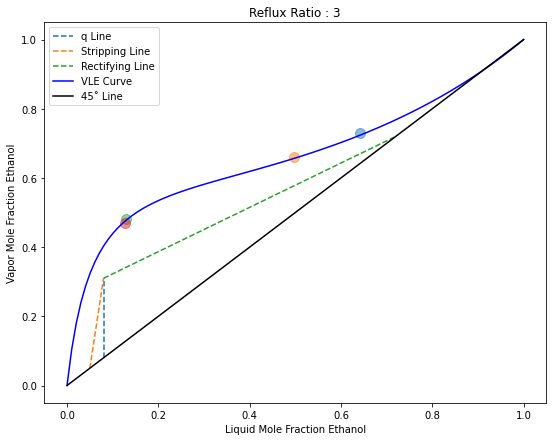

In [75]:
#Lab 3.2
antoine_water = [7.96681, 1668.21,228.00]
antoine_etOH = [8.04494, 1554.30,222.650]

A_12 = 1.6798
A_21 = 0.9227

def antoine (T, A, B, C) :

    log_P_sat = A - B / (T + C)
    P_sat = 10** (log_P_sat)
    return P_sat

def van_laar (x_1) :
    x_2 = 1 - x_1
    log_gamma_1 = A_12 * ( (A_21 * x_2) / (A_12 * x_1 + A_21 * x_2) ) **2
    log_gamma_2 = A_21 * ( (A_12 * x_1 ) /
    (A_12 * x_1 + A_21 * x_2 ) ) **2
    gamma_1 = numpy.exp(log_gamma_1)
    gamma_2 = numpy.exp (log_gamma_2)
    return gamma_1, gamma_2

def vle(T,x_1,P) :

    P1_sat = antoine (T, *antoine_etOH)
    P2_sat = antoine (T, *antoine_water)
    gamma_etOH, gamma_water = van_laar (x_1)

    y_a = gamma_etOH * x_1 * P1_sat / P #2a
    y_b = 1 - (gamma_water * (1 - x_1) * P2_sat) / P #2b
    return y_a - y_b

def calc_y(T,x_1,P):
    P1_sat = antoine(T, *antoine_etOH)
    gamma_etOH, gamma_water = van_laar(x_1)
    
    y_a = gamma_etOH * x_1 * P1_sat / P
    return y_a

xs = numpy. linspace (0, 1, 100)
guess_T = 50
P = 764.54

sol_T = []
sol_y = []
for i in range(len (xs)) :
    sol = scipy.optimize.root(vle, guess_T,args=(xs [i],P)) 
    sol_T.append (sol.x)
    y_i = calc_y(sol.x, xs [i],P)
    sol_y.append (y_i)

qx=[.08,.08]
qy=[.08,.31]
sty=[.05,.31]
stx=[.05,.08]
rx=[.08,.72]
ry=[.31,.72]
plt.figure(figsize=[9,7])
plt.plot(qx,qy,'--',label="q Line")
plt.plot(stx,sty,'--',label="Stripping Line")
plt.plot(rx,ry,'--',label="Rectifying Line")
plt.plot (xs, sol_y,'b',label="VLE Curve") 
plt.plot (xs, xs, 'k',label="45˚ Line")
plt.scatter(x2,.73,s=100, alpha=0.5)
plt.scatter(x4,.66,s=100, alpha=0.5)
plt.scatter(x62,.48,s=100, alpha=0.5)
plt.scatter(x72,.47,s=100, alpha=0.5)
plt.xlabel("Liquid Mole Fraction Ethanol")
plt.ylabel("Vapor Mole Fraction Ethanol")
plt.title("Reflux Ratio : 3")
plt.legend()
plt.plot()